In [1]:

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt


from config import ModelConfig, TrainingConfig, HardwareConfig, DataConfig

import xarray as xr
import torch

import pandas as pd

import os
import glob
import re
import plotly.io as pio

from plotting import Plotting
from visualize_tsne import visualize_tsne

from sklearn.manifold import TSNE

from sklearn.cluster import DBSCAN, KMeans
import hdbscan
from sklearn.neighbors import NearestNeighbors

import seaborn as sns

from VAE_GMM import VAE
from dataset import CustomDataset, DataModule
from torch.utils.data import DataLoader
from sklearn.mixture import GaussianMixture
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib as mpl
import string

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 9,      # Schriftgröße Achsenbeschriftung
    "axes.titlesize": 9,      # Schriftgröße Titel
    "axes.linewidth": 0.5,     # Achsenlinienbreite
    "lines.linewidth": 0.5,    # Linienbreite
    "font.size": 9,           # Grundschriftgröße
    "legend.fontsize": 9,     # Legende
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    # tick_direction
    "xtick.direction": "in",
    "ytick.direction": "in",
    #"figure.figsize": (5.7, 3.5),  # z.B. 145mm x 90mm in inch
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "pgf.preamble": "\n".join([
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[english]{babel}"
    ]),
})


text_width_mm = 145
inches_per_mm = 1/25.4
fig_width_in = text_width_mm * inches_per_mm
fig_height_in = fig_width_in * 0.6
print('loaded')

loaded


In [2]:
import os
import string
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, LogLocator
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from typing import Dict, List, Tuple

# -------------------------------------------------------
# 1) Konstanten
# -------------------------------------------------------
RECON_LOSS_TAG    = "val/loss/recon"
RECON_FACTOR_TAG  = "annealing/recon_factor"
CONST_RECON_FAC   = 0.1

loss2factor = {
    RECON_LOSS_TAG:        RECON_FACTOR_TAG,
    "val/loss/global_kld": "annealing/vae_factor",
    "val/loss/cluster_kld":"annealing/gmm_factor",
    "val/loss/cat_kld":    "annealing/cat_factor",
    "val/loss/var_reg":    "annealing/reg_factor",
}

tag2label = {
    RECON_LOSS_TAG:       "Reconstruction\nLoss",
    "val/loss/global_kld":  "Global KLD\nLoss",
    "val/loss/cluster_kld": "Cluster KLD\nLoss",
    "val/loss/cat_kld":     "Categorical KLD\nLoss",
    "val/loss/var_reg":     "Variance\nRegularization\nLoss",
    "annealing/vae_factor": "Global KLD",
    "annealing/gmm_factor": "GMM KLD",
    "annealing/cat_factor": "Categorical Reg.",
    "annealing/reg_factor": "Variance Reg.",
    RECON_FACTOR_TAG:       "Reconstruction",  # nur „Reconstruction“ in der Legende
}

# Farben‑Mapping
tag2color = { tag: f"C{i}" for i, tag in enumerate(tag2label) }

def load_tensorboard_scalars(
    logdir: str,
    scalar_name: str,
    epoch_length: int = None,
    offset: int = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    ea = EventAccumulator(logdir, size_guidance={'scalars': 0})
    ea.Reload()
    tags = ea.Tags().get('scalars', [])
    if scalar_name not in tags:
        raise ValueError(f"Scalar '{scalar_name}' nicht in {logdir}. Gefundene: {tags}")
    events = ea.Scalars(scalar_name)
    steps = np.array([e.step for e in events], dtype=np.int64)
    vals  = np.array([e.value for e in events], dtype=np.float64)
    if epoch_length is not None:
        if offset is None:
            offset = steps.min()
        epochs = (steps - offset) / epoch_length
    else:
        epochs = None
    return steps, vals, epochs

def plot_training_diagnostics(
    base_dir: str,
    experiments: Dict[str, List[int]],
    loss_tags: List[str],
    anneal_tags: List[str],
    phase_bounds_ep: Dict[str, Tuple[int,int]],
    load_fn,
    epoch_length: int = None,
    epoch_interval: int = 10,
    fig_kwargs: Dict = None,
    plot_kwargs: Dict = None,
    smooth_window: int = 5,
    eps: float = 1e-8,
) -> plt.Figure:
    # ---- Defaults ----
    fig_kwargs  = fig_kwargs or {"figsize": (12, 8)}
    plot_kwargs = plot_kwargs or {"alpha": 0.8, "linewidth": 1.5}

    # ---- Subplots ----
    n_loss = len(loss_tags)
    fig, axs = plt.subplots(
        n_loss+2, 1, sharex=True,
        figsize=fig_kwargs["figsize"],
        gridspec_kw={"height_ratios":[1]*(n_loss+2)}
    )
    axes_loss = axs[:n_loss]
    ax_ann    = axs[n_loss]
    ax_phase  = axs[n_loss+1]

    # Panel‑Labels
    for ax, ch in zip(list(axes_loss)+[ax_ann, ax_phase], string.ascii_lowercase):
        ax.text(0.02, 0.95, f"({ch})",
                transform=ax.transAxes,
                fontsize="large", fontweight="bold",
                va="top", ha="left",
                bbox={"boxstyle":"round,pad=0.16","fc":"white", "ec":"white", "alpha":0.7},
                zorder=10)

    linestyles = ["-", "--", ":", "-.", "."]
    max_x = 0.0

    # ===== 1) Loss-Panels =====
    for i, tag in enumerate(loss_tags):
        ax = axes_loss[i]
        factor_tag = loss2factor[tag]
        color      = tag2color[factor_tag]
        label      = tag2label[tag]

        for exp, vers in experiments.items():
            for j, v in enumerate(vers):
                logdir = os.path.join(base_dir, exp, f"version_{v}")
                steps, vals, epochs = load_fn(logdir, tag, epoch_length, offset=None)

                x    = (epochs if epochs is not None else steps).astype(np.float64)
                vals = vals.astype(np.float64)
                if x.size > 1:
                    x, vals = x[:-1], vals[:-1]

                # --- HIER: manuelles Recon‑Weighting ---
                if tag == RECON_LOSS_TAG:
                    factor_interp = np.full_like(vals, CONST_RECON_FAC)
                else:
                    # dynamische Faktoren aus Logs
                    _, vals_f, _ = load_fn(logdir, factor_tag, epoch_length, offset=None)
                    vals_f = vals_f.astype(np.float64)
                    if vals_f.size > 1:
                        vals_f = vals_f[:-1]
                    factor_interp = np.clip(vals_f, eps, None)

                # Normierung + Glätten
                y_norm = np.divide(vals, factor_interp, out=np.zeros_like(vals), where=(factor_interp>0))
                if smooth_window>1 and y_norm.size>=smooth_window:
                    kern = np.ones(smooth_window)/smooth_window
                    y_plot = np.convolve(y_norm, kern, mode="same")
                else:
                    y_plot = y_norm

                ax.plot(
                    x, y_plot,
                    color     = color,
                    linestyle = linestyles[j % len(linestyles)],
                    **plot_kwargs
                )
                max_x = max(max_x, float(np.max(x)))

        # Auto‑y‑Lim mit Puffer
        ys = np.hstack([ln.get_ydata() for ln in ax.get_lines()])
        ys = ys[np.isfinite(ys)]
        if ys.size:
            ax.set_ylim(ys.min()*0.9, ys.max()*1.1)

        ax.yaxis.set_major_locator(MaxNLocator(2))
        ax.set_ylabel(label, rotation=0, ha='right', va='center', labelpad=15)
        ax.grid(alpha=0.3, linestyle="--")

    # ===== 2) Annealing Weights =====
    ax_ann.set_yscale("log")
    ax_ann.set_ylabel("Annealing\nWeights", rotation=0, ha='right', va='center', labelpad=15)
    ax_ann.yaxis.set_major_locator(LogLocator(numticks=4))
    ax_ann.yaxis.set_minor_locator(LogLocator())

    # plots für alle dynamischen anneal_tags
    for tag in anneal_tags:
        if tag == RECON_FACTOR_TAG:
            # horizontale Linie für konstanten Recon-Faktor
            x0, x1 = 0, 400
            ax_ann.hlines(
                y=CONST_RECON_FAC, xmin=x0, xmax=x1,
                color     = tag2color[RECON_FACTOR_TAG],
                linestyle = "-", linewidth=plot_kwargs.get("linewidth",1.5),
                label     = tag2label[RECON_FACTOR_TAG]
            )
        color = tag2color[tag]
        lbl   = tag2label[tag]
        for exp, vers in experiments.items():
            for j, v in enumerate(vers):
                logdir = os.path.join(base_dir, exp, f"version_{v}")
                steps, vals_f, epochs = load_fn(logdir, tag, epoch_length, offset=None)
                x = (epochs if epochs is not None else steps).astype(np.float64)
                ax_ann.plot(
                    x, vals_f,
                    color     = color,
                    linestyle = linestyles[j % len(linestyles)],
                    label     = lbl if j==0 else "",
                    **plot_kwargs
                )
                max_x = max(max_x, float(np.max(x)))

    

    # Legend, Grid, sichtbare Ticks
    ax_ann.legend(title="Weights", loc='upper left', bbox_to_anchor=(1.01,1.1),
                  fontsize="x-small", frameon=False, handlelength=1)
    ax_ann.grid(alpha=0.5, linestyle="--")
    ax_ann.tick_params(axis='both', which='major', direction='in')
    ax_ann.tick_params(axis='x', labelbottom=True)

    # Phasen‑Linien
    for _, (_, e_ep) in phase_bounds_ep.items():
        ax_ann.axvline(e_ep, color='black', linestyle='--', alpha=1)

    # ===== 3) Phase-Timeline =====
    ax_phase.set_ylim(0, len(phase_bounds_ep))
    ax_phase.set_yticks(np.arange(len(phase_bounds_ep))+0.5)
    ax_phase.set_yticklabels(list(phase_bounds_ep.keys()))
    ax_phase.set_xlabel("Epoch")
    ax_phase.set_autoscale_on(False)
    colors = plt.cm.Pastel1.colors
    for j, (name, (s_ep, e_ep)) in enumerate(phase_bounds_ep.items()):
        ax_phase.broken_barh(
            [(s_ep, e_ep-s_ep)], (j,1),
            facecolor=colors[j % len(colors)], edgecolor='k', alpha=0.6
        )

    # gemeinsames x‑Limit & Ticks
    x_end = max_x - 1 if max_x>=1 else max_x
    ticks = np.arange(0, np.ceil(x_end)+1, epoch_interval)
    for ax in axs:
        ax.set_xlim(0, ticks[-1])
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks.astype(int))

    plt.tight_layout()
    return fig


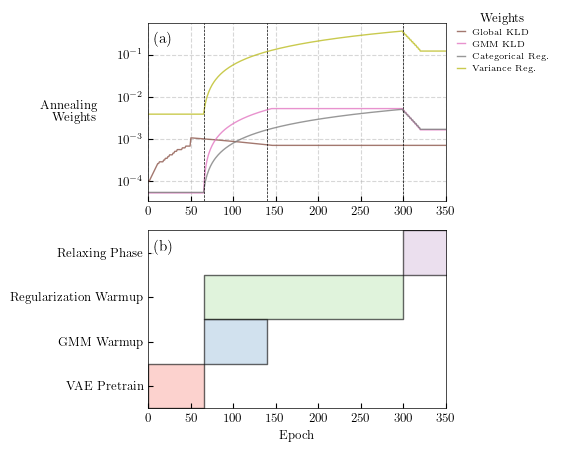

In [5]:
import matplotlib.pyplot as plt


# 1) Basis-Verzeichnis der Logs
base_logs = "/work/aa0238/a271125/logs/Correct_Normalization"

# 2) Experiment-/Version-Definition
experiments = {
    "Experiment_4": [29],  # passe Namen und Versionen an
}

# 3) Welche Loss-Tags sollen geplottet werden?
loss_tags = [
    #"val/loss/recon",
    #"val/loss/global_kld",
    #"val/loss/cluster_kld",
    #"val/loss/cat_kld",
    #"val/loss/var_reg",
]

# 4) Welche Annealing-Tags?
anneal_tags = [
    "annealing/vae_factor",
    "annealing/gmm_factor",
    "annealing/cat_factor",
    "annealing/reg_factor",
]

# 5) Phasen-Bounds (Step-Intervalle)
phase_bounds = {
    "VAE Pretrain":            (0,  65),
    "GMM Warmup":            (65, 140),
    "Regularization Warmup": (65, 300),
    "Relaxing Phase":        (300, 400),
}


# 6) Plot aufrufen
fig = plot_training_diagnostics(
    base_dir=base_logs,
    experiments=experiments,
    loss_tags=loss_tags,
    anneal_tags=anneal_tags,
    phase_bounds_ep=phase_bounds,
    load_fn=load_tensorboard_scalars,
    epoch_length=43,
    epoch_interval=50, 
    fig_kwargs={"figsize": (fig_width_in, fig_width_in*0.8)},
    plot_kwargs={"alpha": 0.8, "linewidth": 1}
)

# 7) Anzeigen
#plt.savefig('./plots/training_schedule_extended.pdf', bbox_inches='tight')
plt.savefig('./plots/training_phases.pdf', bbox_inches='tight')

plt.show()